In [ ]:
from google.colab import drive

In [ ]:
#drive.mount('/content/drive')

In [ ]:
import regex as re
import nltk
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
import numpy as np
from sklearn.metrics import mean_squared_error as MSE, r2_score
from scipy.stats import skew,kurtosis,zscore
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ParticipantData_BTPC/Train.csv")
df.head(3)

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
0,57f879e70d3c5fc2a98102d64c9fd84e,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,236.886
1,a5442b0c7c33d0a811e7661e556b2de8,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,1277.455
2,305cb1486ed8610c00b37007926cb2c4,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0,21.704


In [ ]:
df = df.drop(['session_id'],1)

In [ ]:
df.describe()

,session_number,purchased,added_in_cart,checked_out,time_spent
count,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000
mean,1072.835329,0.159145,0.162092,0.017499,663.194292
std,1436.351474,0.365845,0.368570,0.131132,1713.671664
min,11.000000,0.000000,0.000000,0.000000,14.400000
25%,121.000000,0.000000,0.000000,0.000000,22.699000
50%,517.000000,0.000000,0.000000,0.000000,98.312000
75%,1397.000000,0.000000,0.000000,0.000000,600.463000
max,7722.000000,1.000000,1.000000,1.000000,38494.025000


In [ ]:
df.time_spent.skew()

8.037561600195058

In [ ]:
def distribution_check(df,Cols):
    plt.figure(figsize=(12,7))
    fig = 1
    i = (len(Cols)//3)+1
    for col in Cols:
        sk = " Skewness : " + str(skew(df[col])) +"\nKurtosis :" + str(kurtosis(df[col]))
        plt.subplot(i, 3, fig)
        sns.distplot(df[col]).set_title(sk)
        fig = fig+1

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


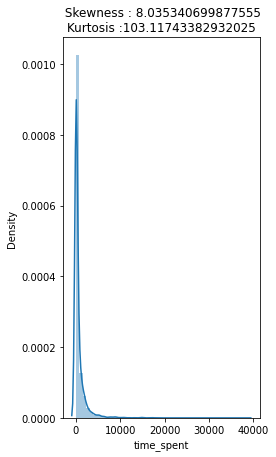

In [ ]:
distribution_check(df,['time_spent'])

In [ ]:
df['time_spent'] = np.log(df['time_spent'])
y = df['time_spent']

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


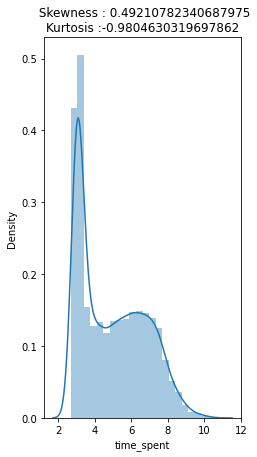

In [ ]:
distribution_check(df,['time_spent'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   session_number  5429 non-null   int64  
 1   client_agent    5269 non-null   object 
 2   device_details  5429 non-null   object 
 3   date            5429 non-null   object 
 4   purchased       5429 non-null   int64  
 5   added_in_cart   5429 non-null   int64  
 6   checked_out     5429 non-null   int64  
 7   time_spent      5429 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 339.4+ KB


In [ ]:
#datetime

In [ ]:
df['Date'] = pd.to_datetime(df.date)
df['weekday'] = df.Date.dt.weekday
df['day'] = df.Date.dt.day
#df['week'] = df.Date.dt.week
df['month'] = df.Date.dt.month
#df['year'] = df.Date.dt.year
df = df.drop(["Date"],1)

In [ ]:
df_num = df[["purchased","added_in_cart","checked_out","weekday","day","month","session_number"]]

In [ ]:
df_txt = df.drop(["purchased","added_in_cart","checked_out","time_spent","session_number","day","month"],1)

In [ ]:
df_num.head(5)

,purchased,added_in_cart,checked_out,weekday,day,month,session_number
0,1,0,0,2,22,1,715
1,1,0,0,3,27,2,55
2,0,0,0,3,1,8,11
3,0,1,0,0,30,12,2794
4,0,0,0,1,10,9,3674


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df_num = scaler.fit_transform(df_num,1)
df_num

array([[1.        , 0.        , 0.        , ..., 0.7       , 0.        ,
        0.09129815],
       [1.        , 0.        , 0.        , ..., 0.86666667, 0.09090909,
        0.00570613],
       [0.        , 0.        , 0.        , ..., 0.        , 0.63636364,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.4       , 0.63636364,
        0.02425107],
       [0.        , 0.        , 0.        , ..., 0.56666667, 0.45454545,
        0.11697575],
       [0.        , 0.        , 0.        , ..., 0.66666667, 0.81818182,
        0.16119829]])

In [ ]:
X_num = df_num

In [ ]:
df_txt['main'] = df_txt[df_txt.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

df_txt.main.head(3)

0    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1    Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-...
2    Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...
Name: main, dtype: object

In [ ]:
X_text = df_txt.main
X_text.head(2)

0    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1    Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-...
Name: main, dtype: object

In [ ]:
import regex as re
model = []
for i in range(0, df.shape[0]):
    data = re.sub(r'\W', ' ', str(X_text[i]))
    data = data.lower()
    data = re.sub(r'^br$', ' ', data)
    data = re.sub(r'\s+br\s+',' ',data)
    data = re.sub(r'\s+[a-z]\s+', ' ',data)
    data = re.sub(r'^b\s+', '', data)
    data = re.sub(r'\s+', ' ', data)
    model.append(data)   

In [ ]:
model[0]

'mozilla 5 0 windows nt 6 1 wow64 applewebkit 537 36 khtml like gecko chrome 40 0 2214 111 safari 537 36 desktop chrome 2020 01 22 2'

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
vector = TfidfVectorizer(max_features = 3000, min_df = 3, max_df = 0.5, stop_words = stopwords.words('english'),ngram_range = (2,2))
X_text = vector.fit_transform(model).toarray()

In [ ]:
X = np.concatenate((X_text,X_num),axis = 1)
X

array([[0.        , 0.        , 0.        , ..., 0.7       , 0.        ,
        0.09129815],
       [0.        , 0.        , 0.        , ..., 0.86666667, 0.09090909,
        0.00570613],
       [0.        , 0.        , 0.        , ..., 0.        , 0.63636364,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.4       , 0.63636364,
        0.02425107],
       [0.        , 0.        , 0.        , ..., 0.56666667, 0.45454545,
        0.11697575],
       [0.        , 0.        , 0.        , ..., 0.66666667, 0.81818182,
        0.16119829]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr = RandomForestRegressor(n_jobs = 4, random_state = 42, n_estimators = 100, verbose = 1, max_features = 'auto', max_depth = 10)

In [ ]:
regr.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   19.0s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [ ]:
import numpy as np

pred1 = regr.predict(X_test) 
rmse = np.sqrt(MSE(y_test, pred1)) 
print("RMSE : % f" %(rmse)) 

RMSE :  1.461650


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
r2_score(y_test,pred1)*100

38.05617632156567

In [ ]:
pred = np.exp(pred1)

In [ ]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(y_test, pred))

3.238452045278915

## Hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [50, 100, 150, 200, 300, 400, 500,]}

In [ ]:
g_search = GridSearchCV(estimator = regr, param_grid = param_grid, 

                          cv = 3, n_jobs = 1, verbose = 1, return_train_score=True)

In [ ]:
g_search.fit(X_train, y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Para

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=4,
                                             oob_score=False, random_state=42,
                                             verbose=1, warm_start=False),
             iid='deprecated', n_jobs=1,

In [ ]:

print(g_search.best_params_)

{'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50}


# Fitting on test set

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ParticipantData_BTPC/Test.csv")
df.head(3)

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out
0,0bf72b05b2cf70dc5e28c3c09f9c4f97,99,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,Desktop - IE,2020-01-07,1,0,0
1,6bc696d99954e4f1367e845465186aef,935,Product/160393 Android/4.3 Device/samsung_GT-I...,Android Phone - Android,2020-02-13,0,0,0
2,3d8611a5ea0f621d205b67f09f663a89,902,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-14,1,0,0


In [ ]:
df = df.drop(['session_id'],1)

In [ ]:
df['Date'] = pd.to_datetime(df.date)
df['weekday'] = df.Date.dt.weekday
df['day'] = df.Date.dt.day
df['week'] = df.Date.dt.week
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df = df.drop(["Date"],1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [ ]:
df_num = df[["purchased","added_in_cart","checked_out","weekday","day","month","session_number"]]

In [ ]:
df_txt = df.drop(["purchased","added_in_cart","checked_out","session_number","day","month"],1)

In [ ]:
df_num = scaler.transform(df_num)
df_num

array([[1.        , 0.        , 0.        , ..., 0.2       , 0.        ,
        0.01141227],
       [0.        , 0.        , 0.        , ..., 0.4       , 0.09090909,
        0.11982882],
       [1.        , 0.        , 0.        , ..., 0.43333333, 0.81818182,
        0.11554922],
       ...,
       [0.        , 0.        , 0.        , ..., 0.43333333, 0.        ,
        0.57346648],
       [1.        , 0.        , 0.        , ..., 0.        , 0.81818182,
        0.03708987],
       [0.        , 1.        , 0.        , ..., 0.7       , 0.09090909,
        0.11269615]])

In [ ]:
X_num = df_num

In [ ]:
df_txt['main'] = df_txt[df_txt.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

df_txt.main.head(3)

0    Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
1    Product/160393 Android/4.3 Device/samsung_GT-I...
2    Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-1...
Name: main, dtype: object

In [ ]:
X_text = df_txt.main
X_text.head(2)

0    Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
1    Product/160393 Android/4.3 Device/samsung_GT-I...
Name: main, dtype: object

In [ ]:
import regex as re
model = []
for i in range(0, df.shape[0]):
    data = re.sub(r'\W', ' ', str(X_text[i]))
    data = data.lower()
    data = re.sub(r'^br$', ' ', data)
    data = re.sub(r'\s+br\s+',' ',data)
    data = re.sub(r'\s+[a-z]\s+', ' ',data)
    data = re.sub(r'^b\s+', '', data)
    data = re.sub(r'\s+', ' ', data)
    model.append(data)   

In [ ]:
X_text = vector.transform(model).toarray()

In [ ]:
X = np.concatenate((X_text,X_num),axis = 1)
X

array([[0.        , 0.        , 0.        , ..., 0.2       , 0.        ,
        0.01141227],
       [0.        , 0.        , 0.        , ..., 0.4       , 0.09090909,
        0.11982882],
       [0.        , 0.        , 0.        , ..., 0.43333333, 0.81818182,
        0.11554922],
       ...,
       [0.        , 0.        , 0.        , ..., 0.43333333, 0.        ,
        0.57346648],
       [0.        , 0.        , 0.        , ..., 0.        , 0.81818182,
        0.03708987],
       [0.        , 0.        , 0.        , ..., 0.7       , 0.09090909,
        0.11269615]])

In [ ]:
predictions = regr.predict(X)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [ ]:
predictions = np.exp(predictions)
predictions

array([542.25632212,  92.09684132, 449.67402884, ...,  85.64742295,
       465.12608977, 614.52220128])

In [ ]:
df_sub = pd.DataFrame(data = predictions, columns=['time_spent'])

In [ ]:
df_sub.to_csv('result.csv')